### **Task 3. Pakistan Case Study**

In [1]:
# importing packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry
from datetime import datetime

sns.set(style="whitegrid")
custom_palette = ['#002a80', '#2c4fab', '#5974d6', '#889eec', '#bac9fe', '#ffe7c0', '#ffcf9f', '#ffb67e', '#ff9b5c', '#ff7d36']

#### Part 1. Build dataset with number of tests purchased (TGF)

Clean Transaction Summary Dataset:

In [2]:
# importing tgf transaction summary dataset - filtered for 'TB molecular diagnostics'
tgf_trans = pd.read_csv('/Users/henriquerodrigues/Desktop/LSE/Y2/Capstone/Data/Input/TGF/transaction_summary.csv', encoding='utf-16', sep='\t')
# dropping first row
tgf_trans = tgf_trans.drop(index=0)

# transforming date columns into datetime format
date_columns = ['Purchase Order Date', 'Scheduled Delivery Date', 'Actual Delivery Date']

for col in date_columns:
    # issue with date columns - 'sept' to 'sep'
    tgf_trans[col] = tgf_trans[col].str.replace('Sept', 'Sep')
    tgf_trans[col] = pd.to_datetime(tgf_trans[col], format='%d-%b-%y')

# transforming columns to numerical
cols_to_num = ['Pack quantity', 'Product pack (USD)', 'Total Product Cost (USD)']

for col in cols_to_num:
    tgf_trans[col] = tgf_trans[col].str.replace(',', '').astype(float)
    tgf_trans[col] = pd.to_numeric(tgf_trans[col], errors='coerce')

# renaming columns
tgf_trans = tgf_trans.rename(columns={"Supplier/Agent/Manufacturer/Intermediatry  ": "Supplier/Agent/Manufacturer/Intermediatry",
                                      "Manufacturer  ": "Manufacturer", 
                                      "Description ": "Description",
                                      "Freight Cost ": "Freight Cost"})

# excluding regional/multicountry observations - e.g. 'Africa', 'Americas', etc.
valid_codes = [country.alpha_3 for country in pycountry.countries]
tgf_trans['Country Code'] = tgf_trans['Grant Name'].str[:3]
tgf_trans = tgf_trans[tgf_trans['Country Code'].isin(valid_codes)]

# change product names
prod_dict = {"Cepheid Xpert MTB/XDR kit (10s) [GXMTB/XDR-10]": "Cepheid Xpert MTB/XDR",
   "Cepheid Xpert MTB/RIF kit (10s, 50s) [CGXMTBRIF]": "Cepheid Xpert MTB/RIF",
   "Cepheid Xpert MTB/RIF Ultra (50s) [GXMTB/RIF-ULTRA-50]": "Cepheid Xpert MTB/RIF Ultra",
   "Cepheid Xpert MTB/RIF Ultra (10s) [GXMTB/RIF-ULTRA-10]": "Cepheid Xpert MTB/RIF Ultra"}

tgf_trans['Description'] = tgf_trans['Description'].map(prod_dict).fillna(tgf_trans['Description'])

# creating column for number of tests in each product pack
tgf_trans['N Units in Pack'] = tgf_trans['Product Pack'].str.extract('(\d+)').astype(int)

# total number of tests per order
tgf_trans['N Units Total'] = tgf_trans['N Units in Pack'] * tgf_trans['Pack quantity']

Filtering for Pakistan:

In [3]:
# keep only Pakistan
tgf_pak = tgf_trans[tgf_trans['Country/Teritorry']=='Pakistan']

In [4]:
tgf_pak_save = tgf_pak[['Country/Teritorry', 'Supplier/Agent/Manufacturer/Intermediatry', 'Description', 'Purchase Order Date', 'Actual Delivery Date', 'N Units Total', 'Total Product Cost (USD)']]

In [5]:
tgf_pak_save

,Country/Teritorry,Supplier/Agent/Manufacturer/Intermediatry,Description,Purchase Order Date,Actual Delivery Date,N Units Total,Total Product Cost (USD)
1343,Pakistan,Global Drug Facility (GDF),Cepheid GeneXpert Model GX-IV- 4 module Instru...,2016-11-09,2016-12-27,39.0,676650.0
1344,Pakistan,Global Drug Facility (GDF),Cepheid GeneXpert Model GX-XVI-16 module instr...,2017-05-12,2017-07-02,3.0,270012.0
1345,Pakistan,Global Drug Facility (GDF),Cepheid GeneXpert Model GX-XVI-16 module instr...,2017-11-02,2017-11-30,3.0,71500.0
1346,Pakistan,Global Drug Facility (GDF),Cepheid Xpert MTB/RIF,2017-03-01,2017-04-20,72250.0,721055.0
1347,Pakistan,Global Drug Facility (GDF),Cepheid Xpert MTB/RIF,2017-06-09,2017-08-02,100600.0,1003988.0
1348,Pakistan,Global Drug Facility (GDF),Cepheid Xpert MTB/RIF,2017-11-02,2017-11-30,100600.0,1003988.0
1349,Pakistan,Global Drug Facility (GDF),Cepheid Xpert MTB/RIF,2017-12-20,2018-02-08,229150.0,2286917.0
1350,Pakistan,Global Drug Facility (GDF),Cepheid Xpert MTB/RIF,2017-12-20,2018-03-12,229150.0,2286917.0
1351,Pakistan,Global Drug Facility (GDF),Cepheid Xpert MTB/RIF,2020-05-12,2020-07-07,50000.0,499000.0
1352,Pakistan,Global Drug Facility (GDF),Cepheid Xpert MTB/RIF,2020-05-12,2020-08-26,100000.0,998000.0


Data Analysis:

In [6]:
tgf_pak['Description'].value_counts()

Description
Cepheid Xpert MTB/RIF                                                           7
Cepheid Xpert MTB/RIF Ultra                                                     3
Cepheid GeneXpert Model GX-XVI-16 module instrument with laptop [GXXVI-16-L]    2
Cepheid GeneXpert Model GX-IV- 4 module Instrument with desktop [GXIV-4D]       1
Name: count, dtype: int64

In [7]:
pd.DataFrame(tgf_pak.groupby('Description')['N Units Total'].sum().reset_index())

,Description,N Units Total
0,Cepheid GeneXpert Model GX-IV- 4 module Instru...,39.0
1,Cepheid GeneXpert Model GX-XVI-16 module instr...,6.0
2,Cepheid Xpert MTB/RIF,881750.0
3,Cepheid Xpert MTB/RIF Ultra,170000.0


In [8]:
tgf_pak

,Country/Teritorry,Grant Name,Supplier/Agent/Manufacturer/Intermediatry,Manufacturer,Product Category,Product,Description,Product Pack,Purchase Order Date,Scheduled Delivery Date,...,Purchase Order Number,Invoice Currency Name,Primary Key,Status,Pack quantity,Product pack (USD),Total Product Cost (USD),Country Code,N Units in Pack,N Units Total
1343,Pakistan,PAK-T-TIH,Global Drug Facility (GDF),Cepheid,"Diagnostic, PPE and Medical Device",TB molecular diagnostics,Cepheid GeneXpert Model GX-IV- 4 module Instru...,1 unit / test,2016-11-09,2016-12-16,...,PAK/IH/16/5924/C,United States Dollar,71867,Admin-Publish,39.0,17350.00,676650.0,PAK,1,39.0
1344,Pakistan,PAK-T-TIH,Global Drug Facility (GDF),Cepheid,"Diagnostic, PPE and Medical Device",TB molecular diagnostics,Cepheid GeneXpert Model GX-XVI-16 module instr...,1 unit / test,2017-05-12,2017-06-16,...,PAK/IH/17/6659/CPHD,United States Dollar,71870,Admin-Publish,3.0,90004.00,270012.0,PAK,1,3.0
1345,Pakistan,PAK-T-TIH,Global Drug Facility (GDF),Cepheid,"Diagnostic, PPE and Medical Device",TB molecular diagnostics,Cepheid GeneXpert Model GX-XVI-16 module instr...,1 unit / test,2017-11-02,2017-11-17,...,00105393,United States Dollar,75233,Admin-Publish,3.0,23833.33,71500.0,PAK,1,3.0
1346,Pakistan,PAK-T-TIH,Global Drug Facility (GDF),Cepheid,"Diagnostic, PPE and Medical Device",TB molecular diagnostics,Cepheid Xpert MTB/RIF,50 tests,2017-03-01,2017-03-25,...,PAK/IH/17/6464,United States Dollar,71872,Admin-Publish,1445.0,499.00,721055.0,PAK,50,72250.0
1347,Pakistan,PAK-T-TIH,Global Drug Facility (GDF),Cepheid,"Diagnostic, PPE and Medical Device",TB molecular diagnostics,Cepheid Xpert MTB/RIF,50 tests,2017-06-09,2017-07-14,...,PAK/IH/17/6810,United States Dollar,71873,Admin-Publish,2012.0,499.00,1003988.0,PAK,50,100600.0
1348,Pakistan,PAK-T-TIH,Global Drug Facility (GDF),Cepheid,"Diagnostic, PPE and Medical Device",TB molecular diagnostics,Cepheid Xpert MTB/RIF,50 tests,2017-11-02,2017-11-17,...,00105393,United States Dollar,75232,Published,2012.0,499.00,1003988.0,PAK,50,100600.0
1349,Pakistan,PAK-T-TIH,Global Drug Facility (GDF),Cepheid,"Diagnostic, PPE and Medical Device",TB molecular diagnostics,Cepheid Xpert MTB/RIF,50 tests,2017-12-20,2017-12-31,...,00116697,United States Dollar,75234,Published,4583.0,499.00,2286917.0,PAK,50,229150.0
1350,Pakistan,PAK-T-TIH,Global Drug Facility (GDF),Cepheid,"Diagnostic, PPE and Medical Device",TB molecular diagnostics,Cepheid Xpert MTB/RIF,50 tests,2017-12-20,2018-01-18,...,PAK/IH/17/7297/CPHD,United States Dollar,93871,Admin-Publish,4583.0,499.00,2286917.0,PAK,50,229150.0
1351,Pakistan,PAK-T-TIH,Global Drug Facility (GDF),Cepheid,"Diagnostic, PPE and Medical Device",TB molecular diagnostics,Cepheid Xpert MTB/RIF,50 tests,2020-05-12,2020-06-25,...,PAK/IH/20/10043/CPHD,United States Dollar,93869,Admin-Publish,1000.0,499.00,499000.0,PAK,50,50000.0
1352,Pakistan,PAK-T-TIH,Global Drug Facility (GDF),Cepheid,"Diagnostic, PPE and Medical Device",TB molecular diagnostics,Cepheid Xpert MTB/RIF,50 tests,2020-05-12,2020-08-24,...,PAK/IH/20/10043/CPHD,United States Dollar,93870,Admin-Publish,2000.0,499.00,998000.0,PAK,50,100000.0


In [9]:
pd.DataFrame(tgf_pak.groupby(tgf_pak['Purchase Order Date'].dt.year)['N Units Total'].sum().reset_index())

,Purchase Order Date,N Units Total
0,2016,39.0
1,2017,731756.0
2,2018,20000.0
3,2019,150000.0
4,2020,150000.0


In [10]:
pd.DataFrame(tgf_pak.groupby(tgf_pak['Actual Delivery Date'].dt.year)['N Units Total'].sum().reset_index())

,Actual Delivery Date,N Units Total
0,2016,39.0
1,2017,273456.0
2,2018,458300.0
3,2019,170000.0
4,2020,150000.0


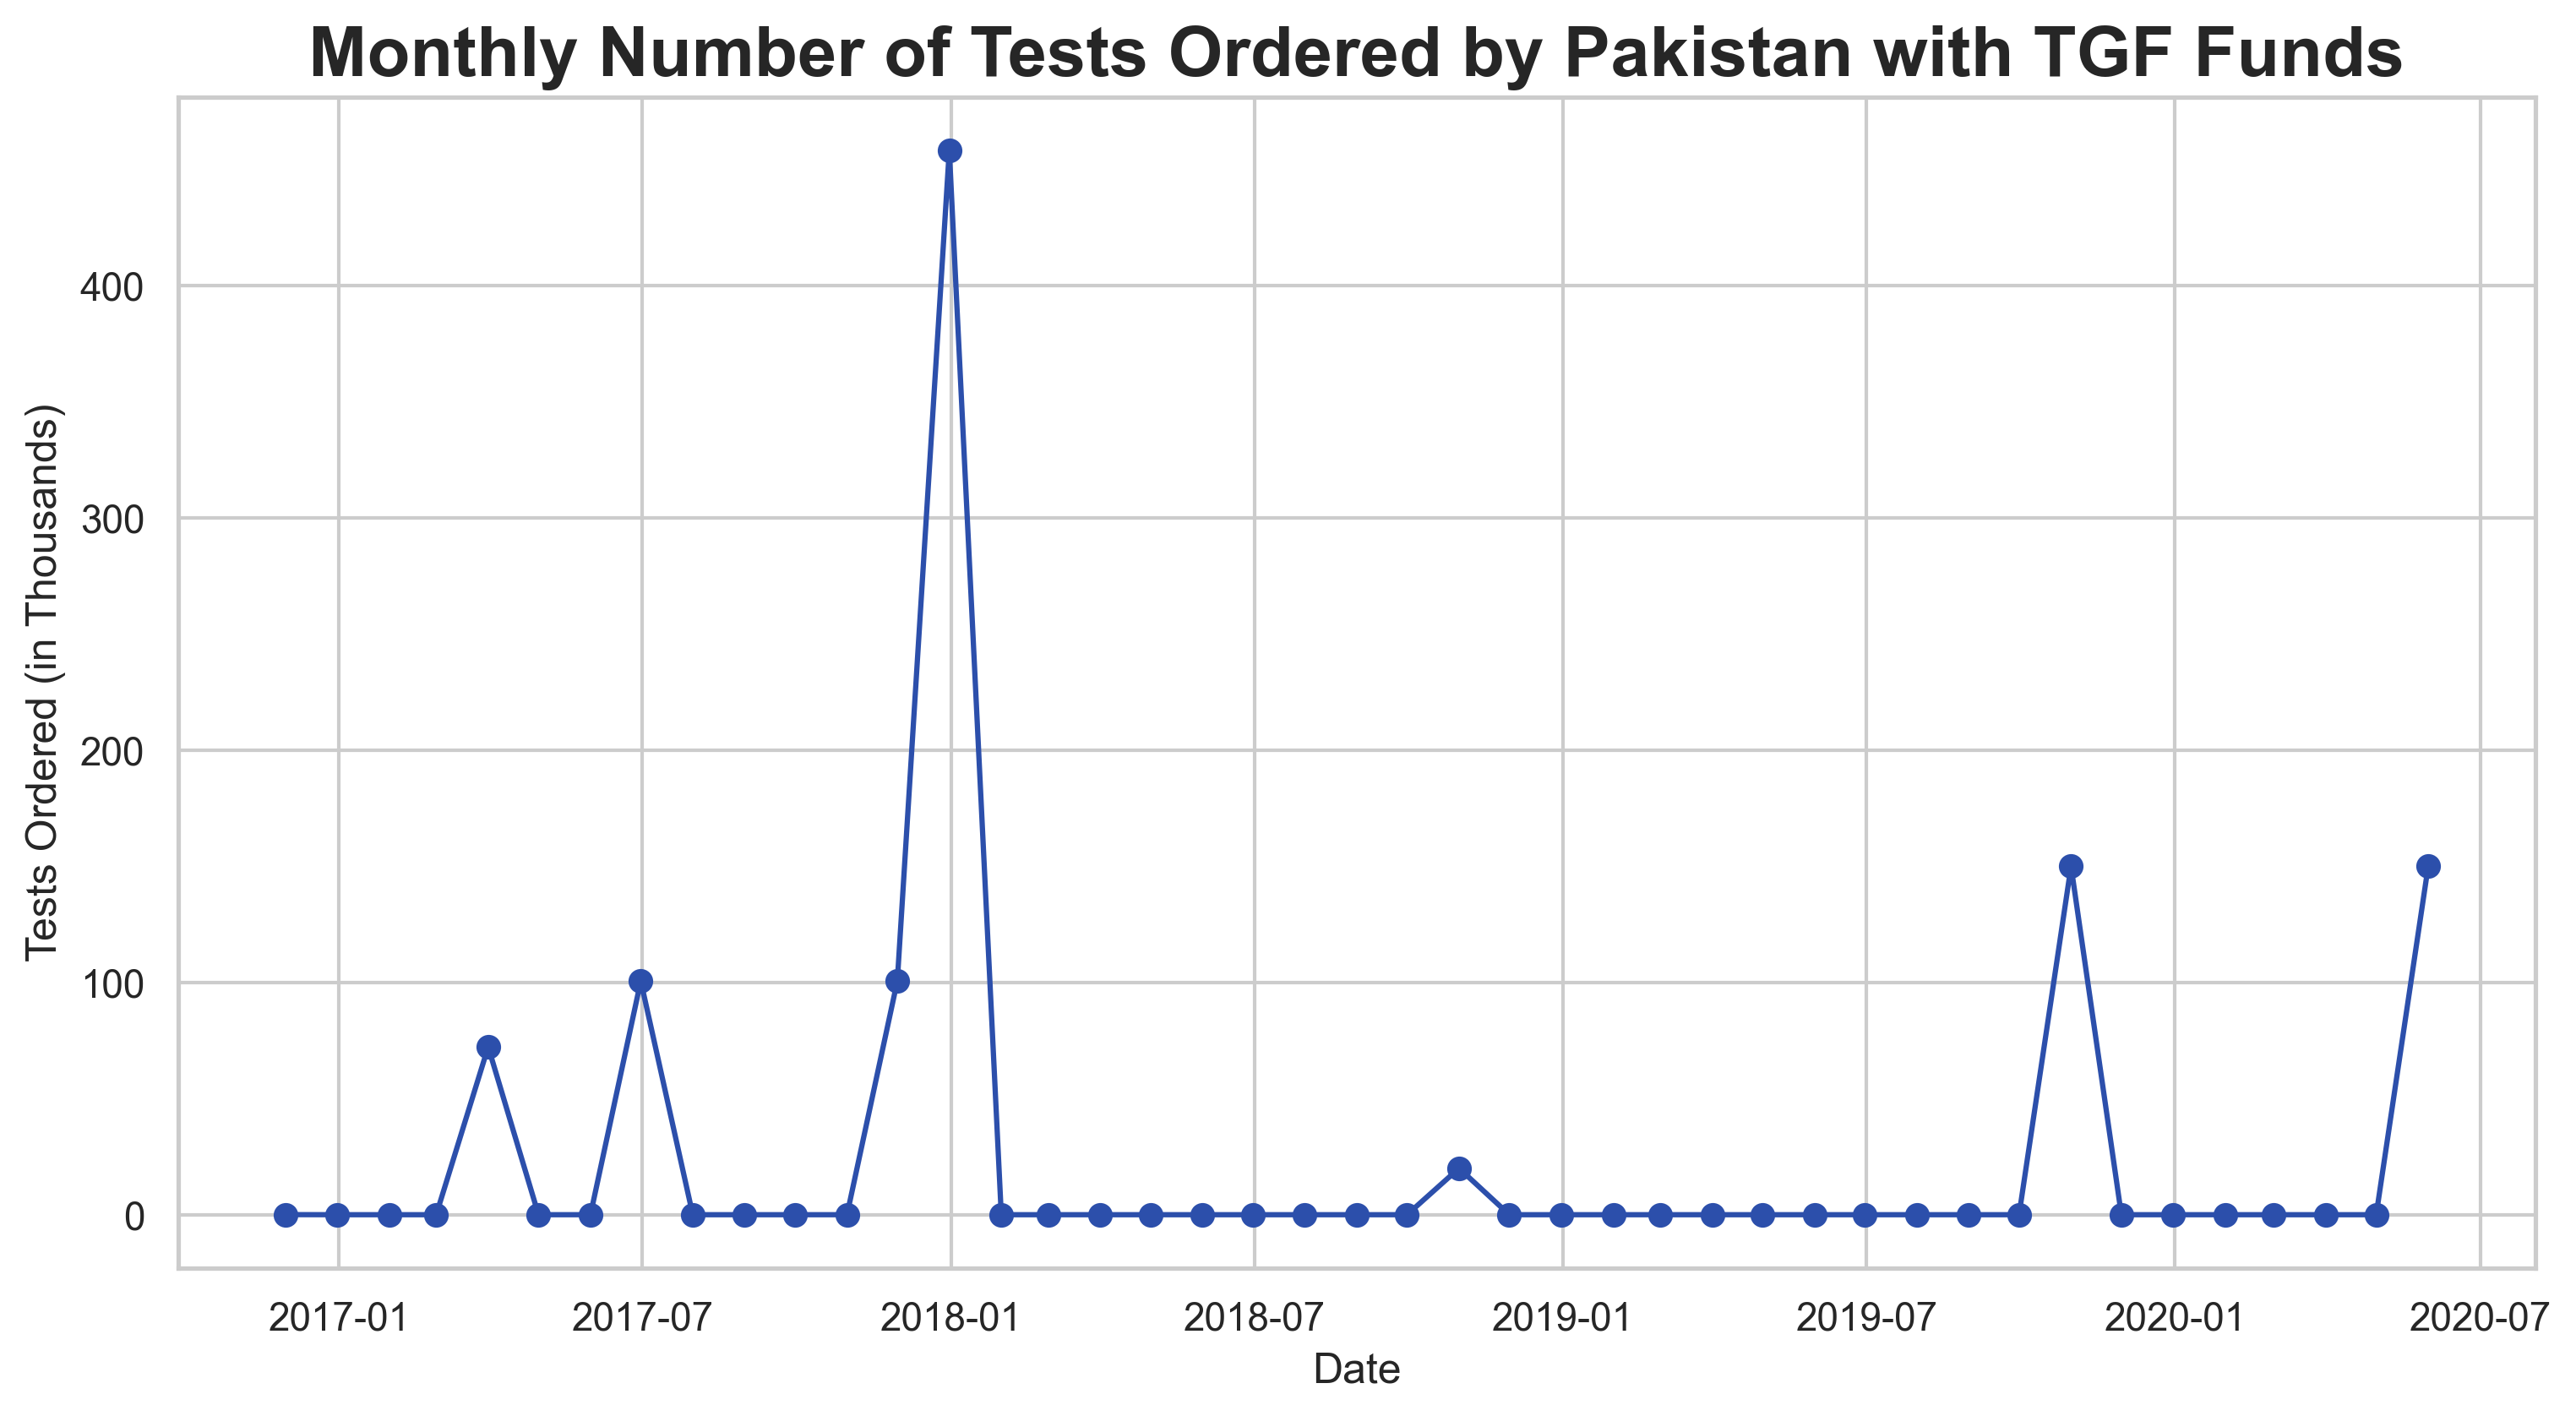

In [11]:
quart_tests = tgf_pak.set_index('Purchase Order Date')['N Units Total'].resample('M').sum()

plt.figure(figsize=(12, 6), dpi=300)
plt.plot(quart_tests.index, quart_tests/1000, marker='o', color='#2c4fab')
plt.title('Monthly Number of Tests Ordered by Pakistan with TGF Funds', fontweight='bold', fontsize=20)
plt.xlabel('Date')
plt.ylabel('Tests Ordered (in Thousands)')
plt.grid(True)
plt.show()

In [77]:
fund = pd.read_csv("/Users/henriquerodrigues/Desktop/LSE/Y2/Capstone/Data/Input/WHO/TB_budget_2024-12-05.csv")

In [78]:
fund_vars = ['country', 'year', 'cf_tot_domestic', 'cf_tot_usaid', 'cf_tot_gf', 'cf_lab', 'cf_tot_grnt', 
             'cf_tot_sources', 'budget_lab', 'budget_tot']

fund = fund[fund_vars]

# removing rows without funding data
rows_to_drop = fund[fund[fund.columns[2:]].isna().all(axis=1)]
fund = fund[~fund.index.isin(rows_to_drop.index)]

fund['budget_gap'] = fund['budget_tot']-fund['cf_tot_sources']
fund['lab_gap'] = fund['budget_lab']-fund['cf_lab']

pak_fun = fund[fund['country']=='Pakistan']

In [79]:
pak_fun['cf_tot_int'] = pak_fun['cf_tot_usaid'] + pak_fun['cf_tot_gf'] + pak_fun['cf_tot_grnt']
plot_df = pak_fun[['year','cf_tot_domestic', 'cf_tot_int', 'budget_tot']]

/var/folders/4h/c_6klx0d0bd723smcqr1l_3h0000gn/T/ipykernel_62126/1643688700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pak_fun['cf_tot_int'] = pak_fun['cf_tot_usaid'] + pak_fun['cf_tot_gf'] + pak_fun['cf_tot_grnt']


In [80]:
pak_fun

,country,year,cf_tot_domestic,cf_tot_usaid,cf_tot_gf,cf_lab,cf_tot_grnt,cf_tot_sources,budget_lab,budget_tot,budget_gap,lab_gap,cf_tot_int
1022,Pakistan,2018,3636632.0,0.0,64022702.0,4237599.0,0.0,67659334.0,28595078.0,118478485.0,50819151.0,24357479.0,64022702.0
1023,Pakistan,2019,3626232.0,0.0,41894665.0,4486118.0,118011.0,45638908.0,31767184.0,135433726.0,89794818.0,27281066.0,42012676.0
1024,Pakistan,2020,3418859.0,0.0,49824819.0,11175224.0,444791.0,53688469.0,35986384.0,157878082.0,104189613.0,24811160.0,50269610.0
1025,Pakistan,2021,3733164.0,19826.0,60326750.0,14350143.0,0.0,64079740.0,55208288.0,152755902.0,88676162.0,40858145.0,60346576.0
1026,Pakistan,2022,4106480.0,0.0,55740707.0,10228053.0,0.0,59847187.0,45465985.0,161570799.0,101723612.0,35237932.0,55740707.0
1027,Pakistan,2023,8755563.0,104808.0,49883409.0,17049530.0,287046.0,59030826.0,45913335.0,158161172.0,99130346.0,28863805.0,50275263.0
1028,Pakistan,2024,7963353.0,0.0,69346933.0,30941211.0,571472.0,77881758.0,30941211.0,77881758.0,0.0,0.0,69918405.0


In [81]:
custom_palette = ['#002a80', '#2c4fab', '#5974d6', '#889eec', '#bac9fe', 
                  '#ffe7c0', '#ffcf9f', '#ffb67e', '#ff9b5c', '#ff7d36']
custom_style = {
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': False,  # Remove left if you want minimal style
    'axes.spines.bottom': False,
    'axes.grid': True,
    'grid.color': '#e1e1e1',  # Light grey grid
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.frameon': False  # No border around legends
}

# Apply custom style and palette
sns.set_palette(custom_palette)
sns.set_theme(style="whitegrid", rc=custom_style) 

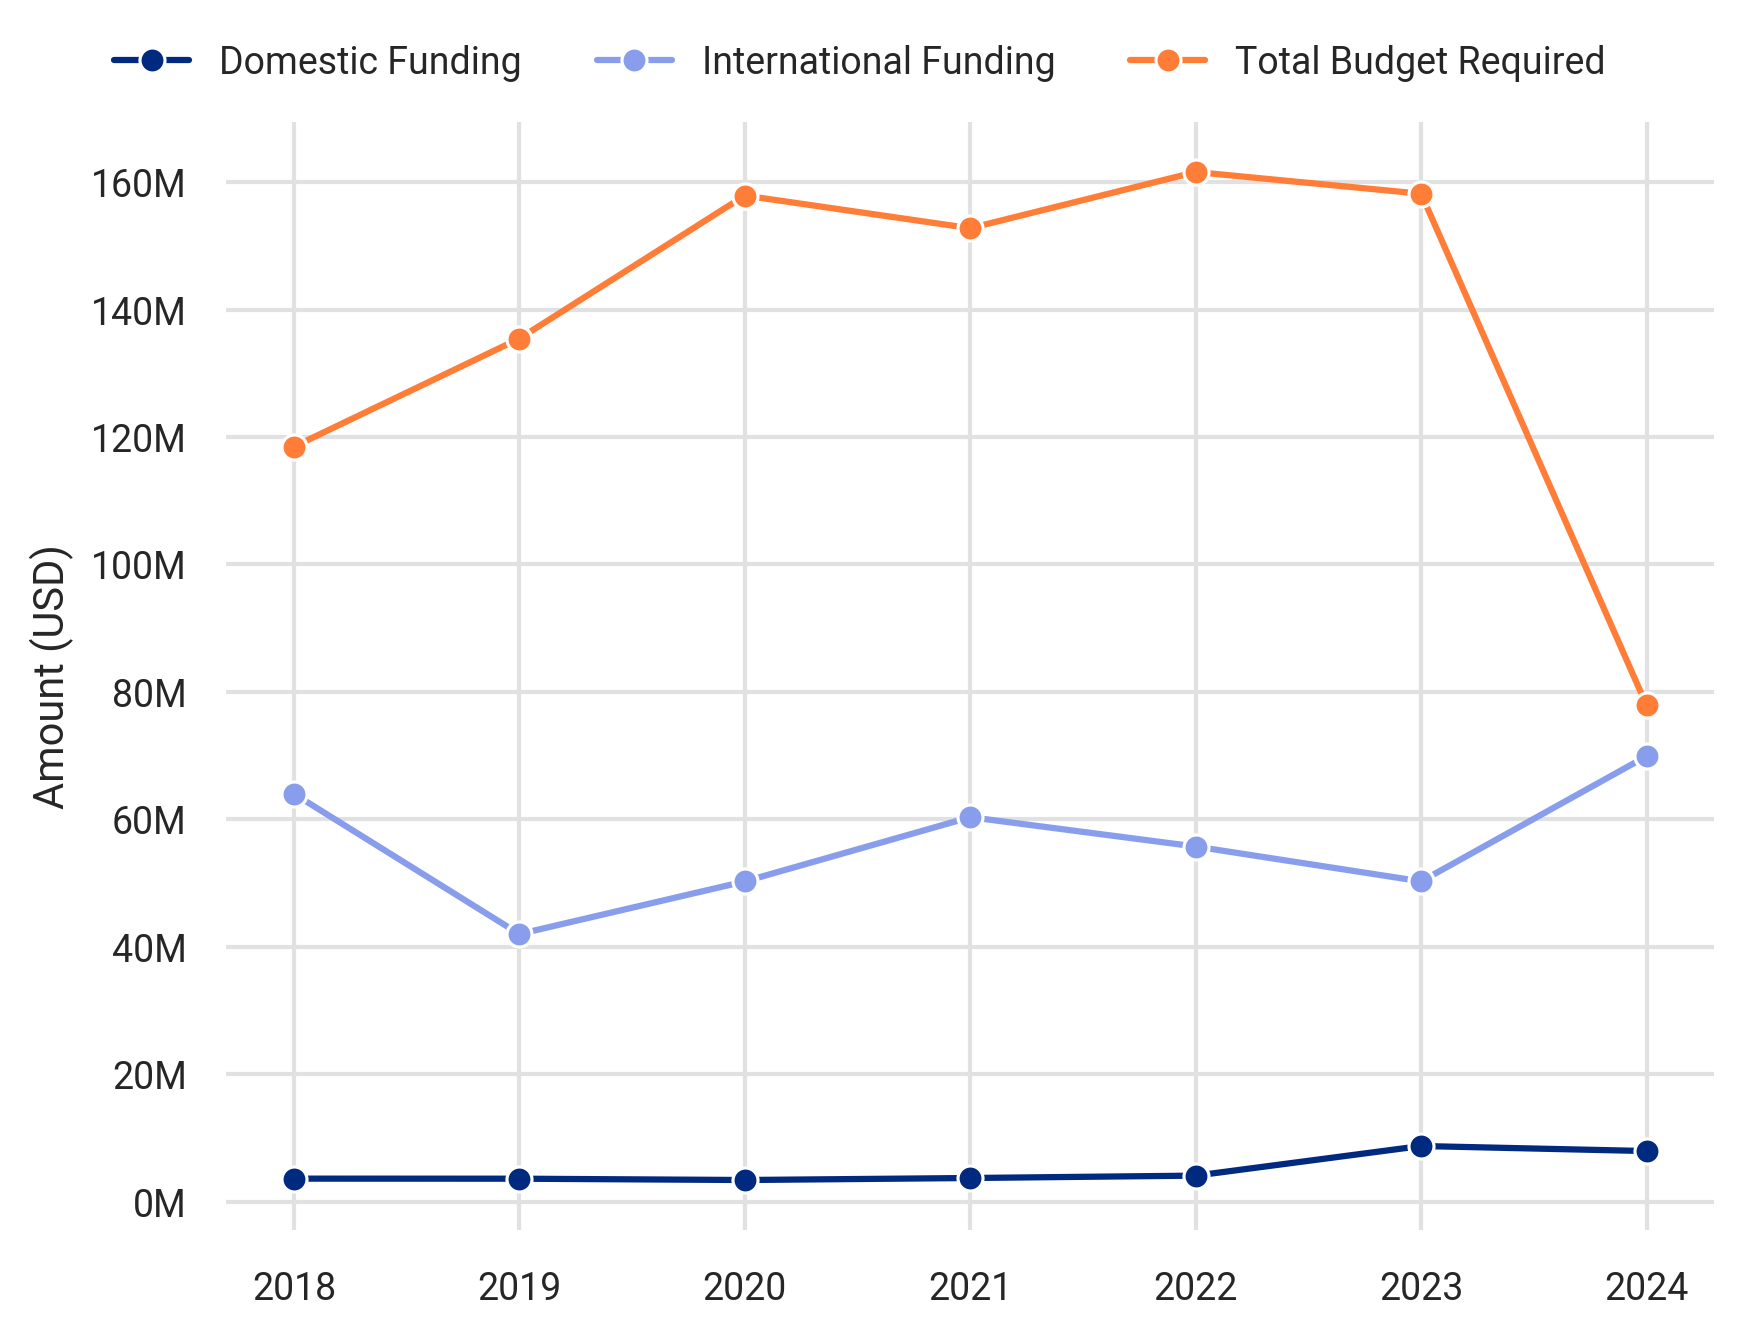

In [82]:
from matplotlib.ticker import FuncFormatter

plt.rcParams.update({
    'font.family': 'Roboto'
})

plt.figure(dpi=300)

# Plot each funding column as a line chart
sns.lineplot(data=plot_df, x="year", y='cf_tot_domestic', label='Domestic Funding', marker='o', color='#002a80')
sns.lineplot(data=plot_df, x="year", y='cf_tot_int', label='International Funding', marker='o', color='#889eec')
sns.lineplot(data=plot_df, x="year", y='budget_tot', label='Total Budget Required', marker='o', color='#ff7d36')

# Add labels and titl
plt.xlabel('')
plt.ylabel('Amount (USD)',fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

formatter = FuncFormatter(lambda x, _: f'{int(x / 1e6):.0f}M')
plt.gca().yaxis.set_major_formatter(formatter)

# Show legend
plt.legend(loc='upper right', bbox_to_anchor=(0.95, 1.1), ncol=3, frameon=False, fontsize=9)

# Show the plot
plt.show()